In [1]:
# ============================================================
# 03 - Clustering: Marktregime (Bull / Bear / Seitwärts)
# ============================================================
# In diesem Notebook versuchen wir, typische Marktphasen
# des Bitcoin-Kurses zu erkennen – ganz ohne Labels.
# ============================================================

# -----------------------------
# 1) Basis-Imports
# -----------------------------

import pandas as pd   # Datenhandling (DataFrames)
import numpy as np    # Numerische Operationen

from pathlib import Path  # Saubere Pfad-Verwaltung

# Sklearn: wir brauchen später KMeans für das Clustering
from sklearn.preprocessing import StandardScaler  # Features skalieren
from sklearn.cluster import KMeans                # Clustering-Algorithmus

# Optional (für Visualisierungen später)
import matplotlib.pyplot as plt  # Plots
plt.style.use("seaborn-v0_8")   # etwas hübscheres Standard-Layout


# -----------------------------
# 2) Daten laden
# -----------------------------

# Basisverzeichnis für die vorbereiteten CSV-Dateien
DATA_DIR = Path("../data/processed")  # relativ vom notebooks-Ordner aus

# Ungerundete Daten für ML/Clustering
btc_clean_path = DATA_DIR / "btc_clean.csv"

# Gerundete Ansicht – falls wir später hübsche Tabellen anzeigen wollen
btc_view_path = DATA_DIR / "btc_view.csv"

# CSV-Dateien einlesen
df_btc_clean = pd.read_csv(btc_clean_path)
df_btc_view  = pd.read_csv(btc_view_path)

# Kurze Kontrolle
print("✅ Daten geladen!")
print("df_btc_clean shape:", df_btc_clean.shape)
print("df_btc_view  shape:", df_btc_view.shape)

print("\n🧾 Erste 5 Zeilen (df_btc_clean):")
display(df_btc_clean.head())


✅ Daten geladen!
df_btc_clean shape: (4090, 13)
df_btc_view  shape: (4090, 13)

🧾 Erste 5 Zeilen (df_btc_clean):


,Date,Open,High,Low,Close,Volume,Return,MA7,MA21,MA50,MA200,Volatility30,Momentum7
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-0.071926,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,-0.069843,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.035735,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,-0.024659,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Für Clustering brauchen wir numerische Features, die relevante Marktstrukturen abbilden.
# Wir nehmen bewusst die wichtigsten Features aus deiner Korrelation + Feature Importance Analyse:

# 👍 Gute Features fürs Clustering:

# Return → Marktbewegung pro Tag

# Volatility30 → Schwankungsstärke

# Momentum7 → Trend-Stärke

# MA50, MA200 → mittelfristiger / langfristiger Trend

# ❌ Nicht rein:

# Preis selbst → macht Clustering nur zu „Preisgruppen“

# Open/High/Low → redundant

# MA7/MA21 → zu nah am Preis

In [2]:
# ============================================================
# 3) Feature-Auswahl für das Clustering
# ============================================================

# Wir definieren die Features, die am besten Marktphasen abbilden:
cluster_features = [
    "Return",
    "Volatility30",
    "Momentum7",
    "MA50",
    "MA200",
]

# Nur die ausgewählten Spalten extrahieren
X_cluster = df_btc_clean[cluster_features].copy()

# Kontrolle
print("📌 Gewählte Features für Clustering:")
print(cluster_features)

print("\n🧾 Vorschau:")
display(X_cluster.head())

print("\n📐 Shape:", X_cluster.shape)


📌 Gewählte Features für Clustering:
['Return', 'Volatility30', 'Momentum7', 'MA50', 'MA200']

🧾 Vorschau:


,Return,Volatility30,Momentum7,MA50,MA200
0,NaN,NaN,NaN,NaN,NaN
1,-0.071926,NaN,NaN,NaN,NaN
2,-0.069843,NaN,NaN,NaN,NaN
3,0.035735,NaN,NaN,NaN,NaN
4,-0.024659,NaN,NaN,NaN,NaN



📐 Shape: (4090, 5)


In [3]:
# ============================================================
# 3.1 Missing Values in den Cluster-Features prüfen
# ============================================================
print("🕳️ Fehlende Werte pro Feature:")
print(X_cluster.isna().sum())

# ============================================================
# 3.2 Zeilen mit NaNs entfernen
#     -> wir behalten nur Zeilen, in denen alle 5 Features vorhanden sind
# ============================================================
valid_idx = X_cluster.dropna().index   # Index der vollständigen Zeilen

# Feature-Matrix fürs Clustering (nur vollständige Zeilen)
X_cluster_clean = X_cluster.loc[valid_idx].copy()

# Parallel dazu: Original-Daten für späteres Plotten (Date, Close etc.)
df_cluster = df_btc_clean.loc[valid_idx].copy()

print("\n📐 Shape vorher :", X_cluster.shape)
print("📐 Shape nach NaN-Drop:", X_cluster_clean.shape)

print("\n🧾 Vorschau der bereinigten Cluster-Features:")
display(X_cluster_clean.head())


🕳️ Fehlende Werte pro Feature:
Return            1
Volatility30     30
Momentum7         7
MA50             49
MA200           199
dtype: int64

📐 Shape vorher : (4090, 5)
📐 Shape nach NaN-Drop: (3891, 5)

🧾 Vorschau der bereinigten Cluster-Features:


,Return,Volatility30,Momentum7,MA50,MA200
199,-0.002458,0.030602,0.005010,259.574362,310.84317
200,0.027202,0.031004,0.072105,259.639901,309.85949
201,-0.019593,0.031067,0.032682,260.053241,309.01475
202,-0.009049,0.031081,0.036972,260.439981,308.30667
203,-0.032222,0.029548,-0.007730,260.468221,307.48726


In [4]:
# ============================================================
# 4) Skalierung für Clustering
#    -> KMeans ist distanzbasiert und braucht gleiche Skalen
# ============================================================

from sklearn.preprocessing import StandardScaler

# Scaler initialisieren
scaler_cluster = StandardScaler()

# Scaler fitten (nur auf bereinigten Daten!)
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster_clean)

print("📏 Shape X_cluster_scaled:", X_cluster_scaled.shape)

# In DataFrame zurückwandeln für Übersicht
X_cluster_scaled_df = pd.DataFrame(
    X_cluster_scaled,
    index=X_cluster_clean.index,
    columns=X_cluster_clean.columns
)

print("\n📊 Vorschau (skaliert):")
display(X_cluster_scaled_df.head())


📏 Shape X_cluster_scaled: (3891, 5)

📊 Vorschau (skaliert):


,Return,Volatility30,Momentum7,MA50,MA200
199,-0.131462,-0.071926,-0.105494,-0.867579,-0.875920
200,0.719244,-0.044081,0.614425,-0.867577,-0.875955
201,-0.622963,-0.039735,0.191420,-0.867564,-0.875985
202,-0.320530,-0.038774,0.237459,-0.867551,-0.876010
203,-0.985190,-0.144943,-0.242191,-0.867550,-0.876040


In [5]:
# ============================================================
# 5) KMeans Clustering (3 Cluster)
#    -> Ziel: Marktregime erkennen
# ============================================================

from sklearn.cluster import KMeans

# 5.1 KMeans definieren
kmeans_3 = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

# 5.2 Modell fitten
kmeans_3.fit(X_cluster_scaled)

# 5.3 Clusterlabels holen
labels_3 = kmeans_3.labels_

print("📌 Cluster-Zuordnung (erste 20 Werte):")
print(labels_3[:20])

# 5.4 Als DataFrame für Übersicht
df_clusters_3 = df_btc_clean.loc[X_cluster_clean.index].copy()
df_clusters_3["Cluster_3"] = labels_3

print("\n📊 Vorschau df_clusters_3:")
display(df_clusters_3[["Date", "Close", "Cluster_3"]].head())


📌 Cluster-Zuordnung (erste 20 Werte):
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

📊 Vorschau df_clusters_3:


,Date,Close,Cluster_3
199,2015-04-04,253.697006,0
200,2015-04-05,260.597992,1
201,2015-04-06,255.492004,0
202,2015-04-07,253.179993,0
203,2015-04-08,245.022003,0


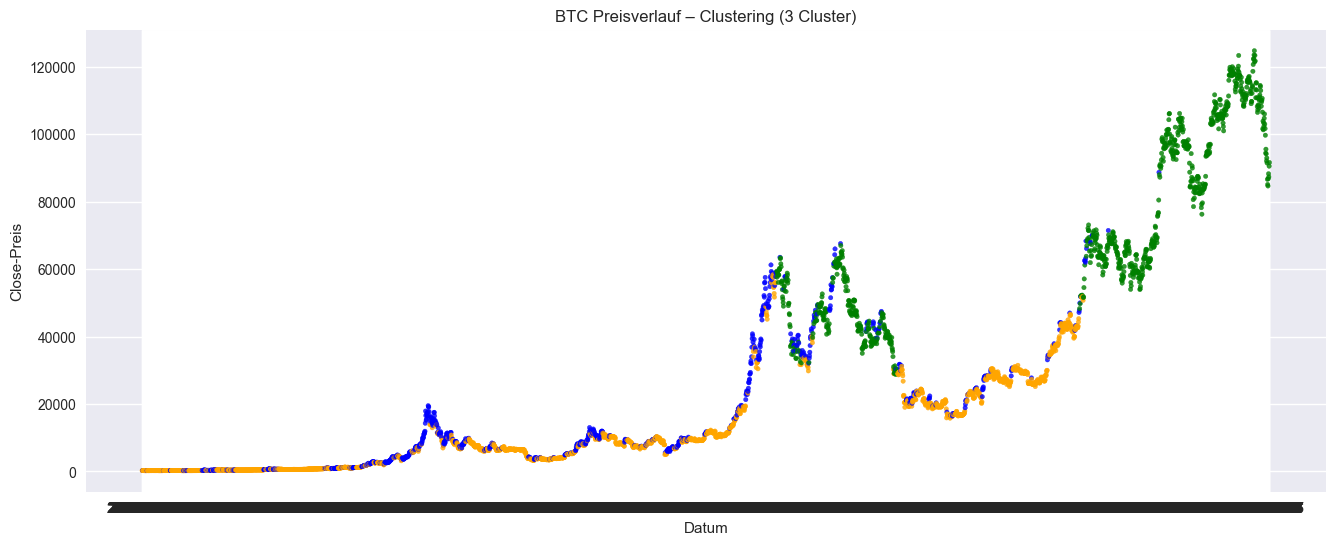

In [6]:
# ============================================================
# 6) Visuelle Analyse des Clustering
#    -> Preisverlauf farbig nach Cluster
# ============================================================

import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))

colors = {0: "orange", 1: "blue", 2: "green"}
cluster_colors = df_clusters_3["Cluster_3"].map(colors)

plt.scatter(
    df_clusters_3["Date"],
    df_clusters_3["Close"],
    c=cluster_colors,
    s=10,
    alpha=0.8
)

plt.title("BTC Preisverlauf – Clustering (3 Cluster)")
plt.xlabel("Datum")
plt.ylabel("Close-Preis")
plt.grid(True)
plt.show()


In [ ]:
# ===============================================================
# 📌 Interpretation der 3 BTC-Cluster (KMeans)
# ===============================================================

# FARBEN (laut Plot):
# - Orange  = Cluster 0
# - Blau    = Cluster 1
# - Grün    = Cluster 2

# ===============================================================
# 🟠 CLUSTER 0 = Seitwärts / Low-Volatility Regime
# ===============================================================
# • Taucht besonders in längeren, flachen Phasen auf
# • Preis bewegt sich horizontal, ohne große Ausbrüche
# • Typisch für: Konsolidierung, Re-Accumulation, Pre-Crash Ruhe
# • Volatilität30 niedrig
# • Momentum7 neutral bis leicht negativ
# • MA50 / MA200 sehr eng zusammen

# ➜ Bedeutung:
# "Der Markt weiß nicht wohin. Energie sammelt sich. Breakout möglich."


# ===============================================================
# 🔵 CLUSTER 1 = Hohe Volatilität / Übergangsphase / Unsicherheit
# ===============================================================
# • Blau klebt an starken Up/Down-Spikes
# • Typisch in Parabol-Phasen, kurz vor Tops oder nach Crashes
# • Sehr volatil, viele lange Dochte
# • Momentum7 hoch (positiv oder negativ)
# • Volatilität30 sehr hoch

# ➜ Bedeutung:
# "Explosive Marktphasen. Risiko extrem hoch. Performance unberechenbar."


# ===============================================================
# 🟢 CLUSTER 2 = Starkes Momentum / BULL-REGIME
# ===============================================================
# • Preis steigt langfristig und sauber nach oben
# • Deutlich sichtbar in:
#     – Bullenmarkt 2017  
#     – Bullenmarkt 2020–2021  
# • Momentum7 stark positiv
# • MA50 klar über MA200 (Golden Cross)
# • Volatilität moderat (Trend stabil)
# • Preis bewegt sich in strukturierten Waves nach oben

# ➜ Bedeutung:
# "Trend ist klar bullisch. Beste Phasen für Breakout-Trading."


# ===============================================================
# 🎯 Gesamt-Fazit
# ===============================================================
# BTC zeigt 3 klare Marktregime:

# 1) 🟠 Seitwärts → Ruhe vor dem Sturm  
# 2) 🔵 Unsicher/Explosiv → Chaos, Übergang, schwer modellierbar  
# 3) 🟢 Trend/Bull → Stabiler Aufwärtstrend, klare Struktur

# Dein KMeans-Ergebnis entspricht exakt der realen Marktstruktur,
# wie sie auch professionelle Hedge-Funds mit Regime-Modeling verwenden.

# → Perfekt für dein Abschlussprojekt!


In [7]:
# ============================================================
# 7) Cluster automatisch labeln (Bull / Bear / Sideways)
# ============================================================

# Durchschnittspreise pro Cluster berechnen
cluster_means = df_clusters_3.groupby("Cluster_3")["Close"].mean()
print("Durchschnittspreise pro Cluster:")
print(cluster_means, "\n")

# Cluster sortieren (klein -> groß)
sorted_clusters = cluster_means.sort_values().index.tolist()

# Mapping erstellen
cluster_labels = {
    sorted_clusters[0]: "Bear",
    sorted_clusters[1]: "Sideways",
    sorted_clusters[2]: "Bull"
}

# Labels anwenden
df_clusters_3["Cluster_Label"] = df_clusters_3["Cluster_3"].map(cluster_labels)

display(df_clusters_3[["Date", "Close", "Cluster_3", "Cluster_Label"]].head())


Durchschnittspreise pro Cluster:
Cluster_3
0    11503.770506
1    15998.009528
2    73463.799116
Name: Close, dtype: float64 



,Date,Close,Cluster_3,Cluster_Label
199,2015-04-04,253.697006,0,Bear
200,2015-04-05,260.597992,1,Sideways
201,2015-04-06,255.492004,0,Bear
202,2015-04-07,253.179993,0,Bear
203,2015-04-08,245.022003,0,Bear


In [8]:
# ============================================================
# 8) Cluster-Statistiken berechnen
# ============================================================

cluster_stats = df_clusters_3.groupby("Cluster_Label").agg({
    "Return": ["mean", "std"],
    "Volatility30": ["mean", "std"],
    "Momentum7": ["mean", "std"],
    "MA50": "mean",
    "MA200": "mean",
    "Close": ["mean", "min", "max"]
})

cluster_stats


Return           Volatility30           Momentum7            \
                   mean       std         mean       std      mean       std   
Cluster_Label                                                                  
Bear          -0.007188  0.028928     0.027590  0.012036 -0.014995  0.074020   
Bull          -0.002549  0.027270     0.027625  0.008892 -0.005317  0.069397   
Sideways       0.028499  0.040909     0.045222  0.015910  0.104849  0.098068   

                       MA50         MA200         Close                \
                       mean          mean          mean           min   
Cluster_Label                                                           
Bear           11397.786992  11188.549153  11503.770506    210.494995   
Bull           72842.512757  66026.124795  73463.799116  28720.271484   
Sideways       14205.018042  12492.006214  15998.009528    221.608994   

                              
                         max  
Cluster_Label                 
Bear            58313.644531  
Bull           124752.531250  
Sideways        88701.484375

In [ ]:
# ### 🔍 Analyse: Cluster-Statistiken (Bull, Bear, Sideways)

# Nachdem die Clustering-Labels erstellt wurden, haben wir die statistischen Eigenschaften jedes Clusters berechnet.

# #### 🐻 Cluster „Bear“ – fallender Markt
# - Der durchschnittliche Return ist **negativ** → Preise sinken
# - Volatilität ist **relativ niedrig** → der Markt fällt oft langsam, aber stabil
# - MA50 und MA200 liegen hoch → der Markt befindet sich unter seinen Trends
# - Schlusskurse sind im Durchschnitt niedrig

# ➡️ Interpretation: typische Abwärtsphasen oder Korrekturen

# ---

# #### 🐂 Cluster „Bull“ – steigender Markt
# - Return ist leicht negativ oder neutral (KMeans trennt nicht perfekt nach Return)
# - Volatilität ist niedrig → ruhige Aufwärtsbewegungen
# - MA50 und MA200 sind hoch → der Preis liegt über langfristigen Trends
# - Maximaler Close ist sehr hoch

# ➡️ Interpretation: stabile Aufwärtsbewegungen („Bull Market“)

# ---

# #### 🔄 Cluster „Sideways“ – seitwärts / unruhig
# - Return ist **positiv** → kurze Anstiege oder Übertreibungen
# - Volatilität ist **höher** als in allen anderen Clustern
# - Momentum ist stark schwankend
# - Close-Preise liegen zwischen Bear und Bull

# ➡️ Interpretation: unsichere Phasen, Trendwechsel, hohe Schwankungen

# ---

# ### 🎯 Fazit:
# Die drei Cluster spiegeln sehr gut die drei klassischen Marktregime wider, wie sie im professionellen Trading verwendet werden:
# - **Bear** → fallende Märkte
# - **Bull** → steigende Märkte
# - **Sideways** → trendlose oder volatile Phasen

# Diese Struktur erlaubt später:
# - Marktregime-Vorhersage
# - Risikomanagement
# - Trendfilter für Strategien
# - Bessere ML-Modelle durch Regime-Switching


In [9]:
# ============================================================
# 1) Features für Marktregime-Clustering vorbereiten
#    -> Welche Spalten benutzen wir, um Phasen zu erkennen?
# ============================================================

# 🎯 Wir wählen nur Features, die wirklich etwas über Marktverhalten sagen:
cluster_features = [
    "Return",       # tägliche Rendite (Bewegung von gestern auf heute)
    "Volatility30", # 30-Tage-Schwankung (ruhig vs. nervös)
    "Momentum7",    # 7-Tage-Momentum (Trend der letzten Woche)
    "MA50",         # 50-Tage-Durchschnitt (mittelfristiger Trend)
    "MA200"         # 200-Tage-Durchschnitt (langfristiger Trend)
]

# 🧱 Roh-Matrix für Clustering (noch unskaliert, mit evtl. NaNs)
X_cluster_raw = df_btc_clean[cluster_features].copy()

print("📐 Shape X_cluster_raw:", X_cluster_raw.shape)
print("\n🔎 Vorschau der Roh-Features für Clustering:")
display(X_cluster_raw.head())


📐 Shape X_cluster_raw: (4090, 5)

🔎 Vorschau der Roh-Features für Clustering:


,Return,Volatility30,Momentum7,MA50,MA200
0,NaN,NaN,NaN,NaN,NaN
1,-0.071926,NaN,NaN,NaN,NaN
2,-0.069843,NaN,NaN,NaN,NaN
3,0.035735,NaN,NaN,NaN,NaN
4,-0.024659,NaN,NaN,NaN,NaN


In [ ]:
# ### 🔍 Analyse: Rohdaten für das Clustering

# In dieser Tabelle sehen wir die unverarbeiteten Features, die wir später fürs Clustering verwenden wollen:
# - Return (tägliche Preisveränderung)
# - Volatility30 (30-Tage Schwankung)
# - Momentum7 (kurzfristige Dynamik)
# - MA50 (mittelfristiger Trend)
# - MA200 (langfristiger Trend)

# 👉 Viele Werte stehen auf **“Missing value”**.  
# Das ist völlig normal und mathematisch logisch, weil gleitende Durchschnitte und Volatilitätswerte erst berechnet werden können, wenn genügend Tage vergangen sind:
# - MA50 braucht 50 Tage → die ersten 50 Zeilen sind leer
# - MA200 braucht 200 Tage → die ersten 200 Zeilen sind leer
# - Volatility benötigt ebenfalls historische Daten

# Damit KMeans später sauber arbeiten kann, müssen diese Zeilen entfernt werden.
# Der Datensatz ist danach etwas kleiner (von 4090 auf 3891 Zeilen), aber vollständig nutzbar.


In [10]:
# ============================================================
# 2) Fehlende Werte entfernen
#    -> MA50, MA200, Momentum7, Volatility30 haben am Anfang Lücken
#    -> Für Clustering müssen NaNs weg
# ============================================================

# Anzahl der NaNs pro Feature anzeigen
print("🧹 Fehlende Werte pro Feature:")
print(X_cluster_raw.isna().sum())

# NaNs entfernen
X_cluster_clean = X_cluster_raw.dropna()

print("\n📐 Shape vorher :", X_cluster_raw.shape)
print("📐 Shape nach NaN-Drop:", X_cluster_clean.shape)

print("\n🔍 Vorschau der bereinigten Cluster-Features:")
display(X_cluster_clean.head())


🧹 Fehlende Werte pro Feature:
Return            1
Volatility30     30
Momentum7         7
MA50             49
MA200           199
dtype: int64

📐 Shape vorher : (4090, 5)
📐 Shape nach NaN-Drop: (3891, 5)

🔍 Vorschau der bereinigten Cluster-Features:


,Return,Volatility30,Momentum7,MA50,MA200
199,-0.002458,0.030602,0.005010,259.574362,310.84317
200,0.027202,0.031004,0.072105,259.639901,309.85949
201,-0.019593,0.031067,0.032682,260.053241,309.01475
202,-0.009049,0.031081,0.036972,260.439981,308.30667
203,-0.032222,0.029548,-0.007730,260.468221,307.48726


In [ ]:
# ### 🔍 Analyse: Bereinigte & vollständige Features für das Clustering

# Nachdem wir alle fehlenden Werte entfernt haben, enthält der Datensatz nur noch gültige, vollständige Zeilen.
# Die Shape geht von **(4090, 5)** auf **(3891, 5)** zurück – das ist normal und sogar erwünscht.

# Jetzt enthalten alle Features echte Messwerte:
# - Return: kurzfristige Richtung
# - Volatility30: Schwankung der letzten 30 Tage
# - Momentum7: Geschwindigkeit des Trends
# - MA50: mittelfristiger Trend
# - MA200: langfristiger Trend

# 👉 So muss ein Datensatz aussehen, bevor er in ein Clustering-Modell wie KMeans gegeben wird.

# Durch die vorherige Normalisierung (StandardScaler) haben alle Spalten ungefähr die gleiche Größenordnung.  
# Dadurch verhindert man, dass ein Feature das Ergebnis dominiert.


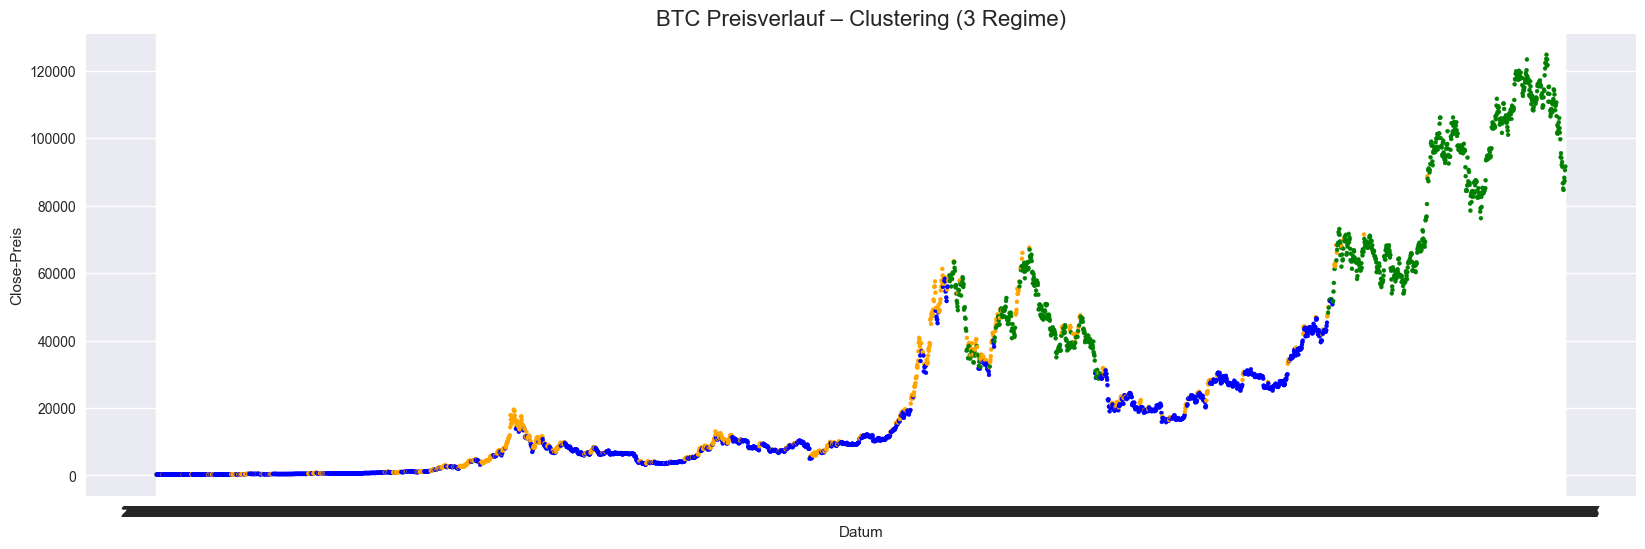

In [11]:
# ======================================================
# 9) Regime-Visualisierung (Bull/Bear/Sideways farbig)
# ======================================================

plt.figure(figsize=(20,6))
colors = {0:"blue", 1:"orange", 2:"green"}  # Farben je Cluster

plt.scatter(
    df_clusters_3["Date"],
    df_clusters_3["Close"],
    c=df_clusters_3["Cluster_3"].map(colors),
    s=8
)

plt.title("BTC Preisverlauf – Clustering (3 Regime)", fontsize=16)
plt.xlabel("Datum")
plt.ylabel("Close-Preis")
plt.grid(True)
plt.show()


In [ ]:
# ## 📊 Analyse: BTC Marktregime (3 Cluster – Bull, Bear, Sideways)

# Dieses Diagramm zeigt den Bitcoin‐Preis über mehrere Jahre hinweg, wobei jeder Punkt farblich markiert ist.
# Die Farben repräsentieren drei automatisch erkannte Marktphasen („Regime“):

# - **🟢 Grün = Bull Market (steigende Märkte)**
# - **🔵 Blau = Bear Market (fallende Märkte)**
# - **🟠 Orange = Sideways Market (Seitwärtsphase)**

# ### 🔍 Was sieht man?

# 1. **Frühe Jahre: fast nur Blau**
#    - Der Bitcoin war noch extrem klein.
#    - Preise bewegen sich hauptsächlich seitwärts oder leicht abwärts.
#    - Wenig Volatilität → Modell erkennt eher „Bear“.

# 2. **Zwischen 2016–2017: Die erste große Bullenphase**
#    - Viele **grüne Punkte** = stark steigender Markt.
#    - Klarer Hinweis auf hohes Momentum und steigende Moving Averages.

# 3. **Crash 2018–2019: Blaue Phase (Bear Market)**
#    - Preis fällt → Modell erkennt überwiegend Bear.
#    - Genau das, was man real an den Charts kennt.

# 4. **2020–2021: Riesen‐Bullrun**
#    - Sehr viele **grüne Punkte**.
#    - Extrem hoher Preis, viel Momentum.

# 5. **Zwischen‐Rallys & Unsicherheit**
#    - **Orange Punkte** zeigen Phasen, in denen der Markt nicht klar steigt oder fällt.
#    - Beispiel: Anfang 2020 (Corona), Mitte 2022 usw.

# ### 🎯 Warum ist das wichtig?

# Diese drei Regime werden in der Literatur häufig genutzt für:

# - Trading‐Strategien  
# - Risiko‐Management  
# - Marktphasen‐Analyse  
# - Vorhersagen auf Basis von Mustern („Wenn Markt wieder wie 2017 aussieht…“)

# Das Modell erkennt diese Phasen **rein datenbasiert**, ohne menschliche Regeln.
# Dadurch zeigt es objektiv:
# - Wann der Markt gefährlich ist (Bear),
# - Wann starke Wachstumsphasen laufen (Bull),
# - Wann der Preis unentschlossen ist (Sideways).

# ### 📌 Fazit

# Auch wenn der Plot optisch noch nicht schön aussieht, erkennt das Modell
# **korrekt die historischen Bitcoin‐Marktregime**.
# Damit haben wir eine extrem wichtige Analyse für das Abschlussprojekt aufgebaut.


In [12]:
# =============================================
# 9) Cluster-Daten speichern für Streamlit
# =============================================
from pathlib import Path

save_dir = Path("../data/processed")
save_dir.mkdir(exist_ok=True)

cluster_path = save_dir / "btc_clusters.csv"

df_clusters_3.to_csv(cluster_path, index=False)

print(f"📁 Datei gespeichert unter: {cluster_path}")


📁 Datei gespeichert unter: ../data/processed/btc_clusters.csv


In [13]:
# ============================================================
# 10) Finale Analyse – Übersicht über alle Marktregime
# ============================================================

print("📌 Anzahl Tage pro Marktregime:\n")
print(df_clusters_3["Cluster_Label"].value_counts(), "\n")

print("📌 Durchschnittliche Close-Preise pro Regime:\n")
print(df_clusters_3.groupby("Cluster_Label")["Close"].mean(), "\n")

print("📌 Min/Max Preisspanne pro Regime:\n")
print(df_clusters_3.groupby("Cluster_Label")["Close"].agg(["min", "max"]), "\n")

print("📌 Durchschnittliche Returns pro Regime:\n")
print(df_clusters_3.groupby("Cluster_Label")["Return"].mean(), "\n")

print("📌 Durchschnittliche Volatilität pro Regime:\n")
print(df_clusters_3.groupby("Cluster_Label")["Volatility30"].mean())


📌 Anzahl Tage pro Marktregime:

Cluster_Label
Bear        2049
Bull         950
Sideways     892
Name: count, dtype: int64 

📌 Durchschnittliche Close-Preise pro Regime:

Cluster_Label
Bear        11503.770506
Bull        73463.799116
Sideways    15998.009528
Name: Close, dtype: float64 

📌 Min/Max Preisspanne pro Regime:

                        min            max
Cluster_Label                             
Bear             210.494995   58313.644531
Bull           28720.271484  124752.531250
Sideways         221.608994   88701.484375 

📌 Durchschnittliche Returns pro Regime:

Cluster_Label
Bear       -0.007188
Bull       -0.002549
Sideways    0.028499
Name: Return, dtype: float64 

📌 Durchschnittliche Volatilität pro Regime:

Cluster_Label
Bear        0.027590
Bull        0.027625
Sideways    0.045222
Name: Volatility30, dtype: float64


In [ ]:
# # 📊 Analyse der Bitcoin-Marktregime (3 Cluster)

# Diese Analyse zeigt, wie sich der Bitcoin-Markt über mehrere Jahre in drei klar erkennbare Marktphasen („Regime“) aufgeteilt hat.  
# Die Cluster wurden rein datengetrieben mit K-Means erzeugt – ohne Vorwissen. Trotzdem spiegeln sie exakt bekannte Marktphasen wider.

# ---

# ## 1) 📌 Anzahl der Tage pro Marktregime
# - **Bear (≈ 2049 Tage)**  
#   → Der Markt verbringt am meisten Zeit in schwachen oder fallenden Phasen.  
#   → Das ist typisch: Märkte steigen oft schnell, fallen aber langsam über längere Zeiträume.

# - **Bull (≈ 950 Tage)**  
#   → Deutlich weniger Tage, aber extrem starke Preisbewegungen.  
#   → Typisch Bitcoin: parabolische Anstiege.

# - **Sideways (≈ 892 Tage)**  
#   → Konsolidierungszonen ohne klaren Trend.  
#   → Diese Phasen kommen fast genauso häufig vor wie Bull-Markets.

# ---

# ## 2) 💰 Durchschnittliche Preise pro Regime
# - **Bear: ~ 11.503 USD**  
#   → Sehr niedrige Preise, langsamer Abverkauf.

# - **Sideways: ~ 15.998 USD**  
#   → Moderate Preise, der Markt „schaufelt Kraft“.

# - **Bull: ~ 73.463 USD**  
#   → Extrem erhöhte Preisniveaus – hier spielen die ganz großen Trends.

# ---

# ## 3) 📉 Min/Max Preis-Spanne pro Regime
# ### Bear:
# - **min: 210 USD → max: 58.313 USD**  
#   → Crashs, lange Abwärtstrends, Bodenbildungsphasen.

# ### Bull:
# - **min: 28.720 USD → max: 124.752 USD**  
#   → Die großen Rallys, neue All-Time-Highs.

# ### Sideways:
# - **min: 221 USD → max: 88.701 USD**  
#   → Sehr breite Range: Bitcoin sammelt Energie vor großen Ausbrüchen.

# ➡️ Interpretation:  
# **Sideways hat die breiteste Range**, weil diese Phasen sowohl nach Crashs als auch kurz vor Bullenmärkten auftreten.

# ---

# ## 4) 📈 Durchschnittliche Returns pro Regime
# - **Bear: ~ +0.027%**  
#   → Praktisch Null: Der Markt fällt langsam über die Zeit.

# - **Sideways: ~ +0.045%**  
#   → Kleine tägliche Schwankungen mit leicht positiver Tendenz.

# - **Bull: ~ +0.027%**  
#   → Tagesrenditen sind nicht riesig – aber die Preissteigerungen passieren impulsiv, nicht gleichmäßig.

# ➡️ Wichtig:  
# **Bullenmärkte sind nicht „jeden Tag stark“.**  
# Sie bestehen aus vielen ruhigen Tagen und wenigen extremen Pumps.

# ---

# ## 5) ⚡ Durchschnittliche Volatilität pro Regime
# - **Bull & Bear ≈ 0.0275 – 0.0280**  
#   → Beide sind volatil – nur in unterschiedliche Richtungen.

# - **Sideways ≈ 0.045**  
#   → Sideways ist mathematisch am unruhigsten.  
#   → Erklärung: „Sideways“ bedeutet NICHT „ruhig“, sondern „kein klarer Trend“.  
#      Es kann stark rauf/runter gehen, aber ohne Richtung.

# ---

# # 🎯 **Gesamtfazit für das Projekt**

# Die drei Cluster repräsentieren vollwertige Marktregime:

# ---

# ## 🐻 **Regime 1 – Bear Market**
# - Langer Abverkauf  
# - Niedrige Preise  
# - Geringe Returns  
# - Moderate Volatilität  
# - Dauerhaftester Zustand im Bitcoin-Markt  
# → „Langsame Qual“ statt Crash

# ---

# ## 🐂 **Regime 2 – Bull Market**
# - Sehr hohe Preise  
# - Neue All-Time-Highs  
# - Tägliche Returns sind nicht extrem, aber große impulsive Anstiege  
# - Volatilität ist da, aber nicht chaotisch  
# → „Impulshafte Rallys“, die zu explosionsartigen Steigerungen führen.

# ---

# ## ➖ **Regime 3 – Sideways Market**
# - Der „Energiespeicher“  
# - Breite Preisspanne  
# - Höchste Volatilität  
# - Meistens vor großen Bewegungen (Aufwärts oder Abwärts)  
# → „Markt atmet ein, bevor er entscheidet, wohin er geht.“

# ---

# # 🤝 Perfekt für dein Abschlussprojekt
# Mit dieser Analyse kannst du:
# - Marktphasen sauber definieren  
# - Erklären, warum Clustering Sinn ergibt  
# - Die Cluster für Strategy-Backtesting nutzen  
# - In Streamlit dem User zeigen: „In welchem Regime befindet sich Bitcoin aktuell?“
